In [35]:
library("readxl")
library(rvest) # scrap web pages
library(reticulate)  # R & python interchange
library(tidyverse)

## Import BIB data
- https://bibliometrix.org/documents/bibliometrix_Report.html
- Place your bibtex files in bibs folder

In [21]:
# Reading Bibtex
# assuming that you are in the same directory as this snippet
library(bibliometrix)
bibs <- list.files("bibs/", pattern = "bib$", recursive = T, full.names = T)
bibs # visualize the files, index start at 1

[1] "bibs//cochrane.bib"  "bibs//savedrecs.bib" "bibs//scopus.bib"

In [ ]:
M <- convert2df(file=bibs[2], dbsource = "isi", format = "bibtex")

## Import xlsx data
File extracted from StArt Tool

In [ ]:
my_data <- read_excel("bibs/arquivos.xlsx")
sub_data <- my_data[my_data$`Status/Selection` == "ACCEPTED",]
names(sub_data) # visualize columns names

# Export to document
Working

# Manipulating the data
This section depicts the two techniques compared in this work. <br/>
LDA vs Our proposal

In [28]:
# create new column combining title, abstract and keywords
sub_data <- sub_data %>%
mutate(fog = paste(sub_data$Title, sub_data$Abstract, sub_data$Keywords))

In [29]:
# capture only these columns
temp_subdata <- sub_data %>%
select (Title, DOI, Year, fog)

### Topic Modeling

In [53]:
# transform column fog to Document term matrix
library(quanteda)
data.dtm <- corpus(temp_subdata, text_field = "fog")
dfm(text, remove_punct = TRUE) %>%
  dfm_remove(stopwords("en"))
data.dtm <- dfm(data.dtm, remove_punct = TRUE)
data.dtm

Document-feature matrix of: 204 documents, 7,363 features (98.3% sparse) and 3 docvars.
       features
docs    from high-level modeling toward efficient and trustworthy circuits
  text1    1          1        1      1         2  10           1        1
  text2    2          0        0      0         0   9           0        0
  text3    0          0        1      0         0   5           0        0
  text4    0          0        0      0         0   5           0        0
  text5    0          0        0      0         0   2           0        0
  text6    0          0        0      0         0   7           0        0
       features
docs    behavior-interaction-priority (
  text1                             1 3
  text2                             0 2
  text3                             0 1
  text4                             0 0
  text5                             0 2
  text6                             0 1
[ reached max_ndoc ... 198 more documents, reached max_nfeat ... 7,353 more

In [61]:
library(tidytext)
data.dtm <- tidy(data.dtm) %>% cast_dtm(document, term, count)

In [71]:
library(ldatuning)
library(topicmodels)
tunningresult <- FindTopicsNumber(
data.dtm,
topics = seq(from = 2, to = 20, by = 1),
metrics = c("Griffiths2004", "CaoJuan2009", "Arun2010", "Deveaud2014"),
method = "Gibbs",
control = list(seed = 77),
mc.cores = 2L,
verbose = TRUE)

fit models... done.
calculate metrics:
  Griffiths2004... done.
  CaoJuan2009... done.
  Arun2010... done.
  Deveaud2014... done.


You can run this snnipet as many times as you’d like, varying the number of CPU cores to suit your needs.

Observe carefully the graph above, it suggests a model with k between 16 and 19, we’ll choose k=17

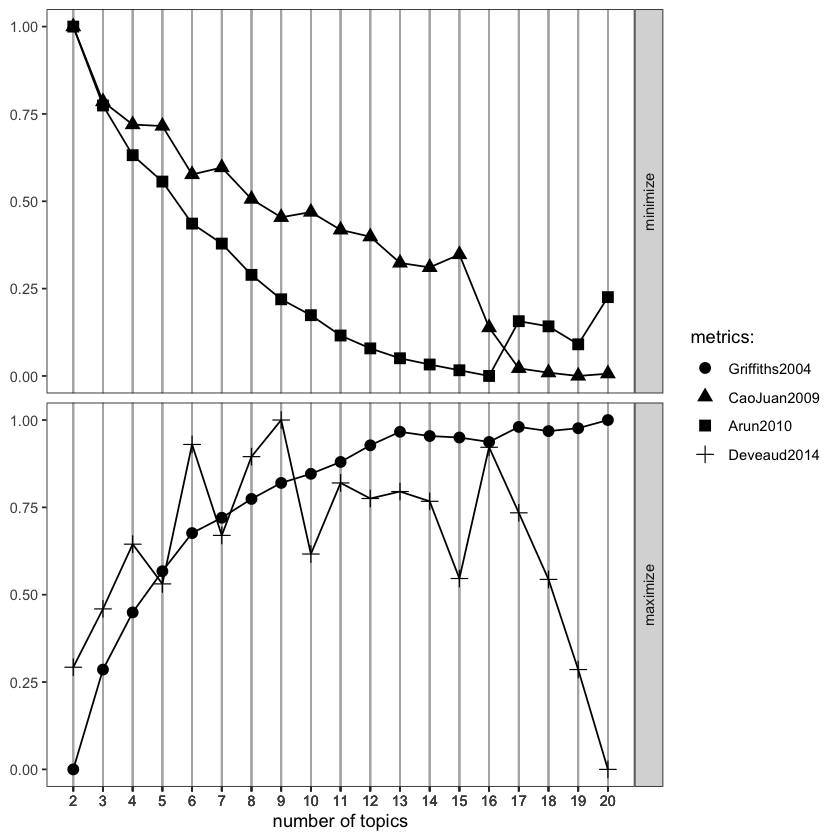

In [72]:
FindTopicsNumber_plot(tunningresult)

Observe the value of k and the method used, you have two options (VEM or Gibbs)
matrix Whether to tidy the beta (per-term-per-topic, default) or gamma (per-document-per-topic) matrix

In [75]:
data.dtm.lda <- LDA(data.dtm, k=17, control=list(seed=77), method="Gibbs")
data.dtm.topics <- tidy(data.dtm.lda, matrix = "beta")
# optional: to visualize the data uncomment below
#my.pdf.ap_topics

Warning message:
“`tbl_df()` is deprecated as of dplyr 1.0.0.
Please use `tibble::as_tibble()` instead.
This warning is displayed once every 8 hours.
Call `lifecycle::last_warnings()` to see where this warning was generated.”


In [77]:
data.dtm.top_terms <- data.dtm.topics %>%
  group_by(topic) %>%
  top_n(10, beta) %>%
  ungroup %>%
  arrange(topic, -beta)
# optional: to visualize the data uncomment below
#my.pdf.aptop_terms

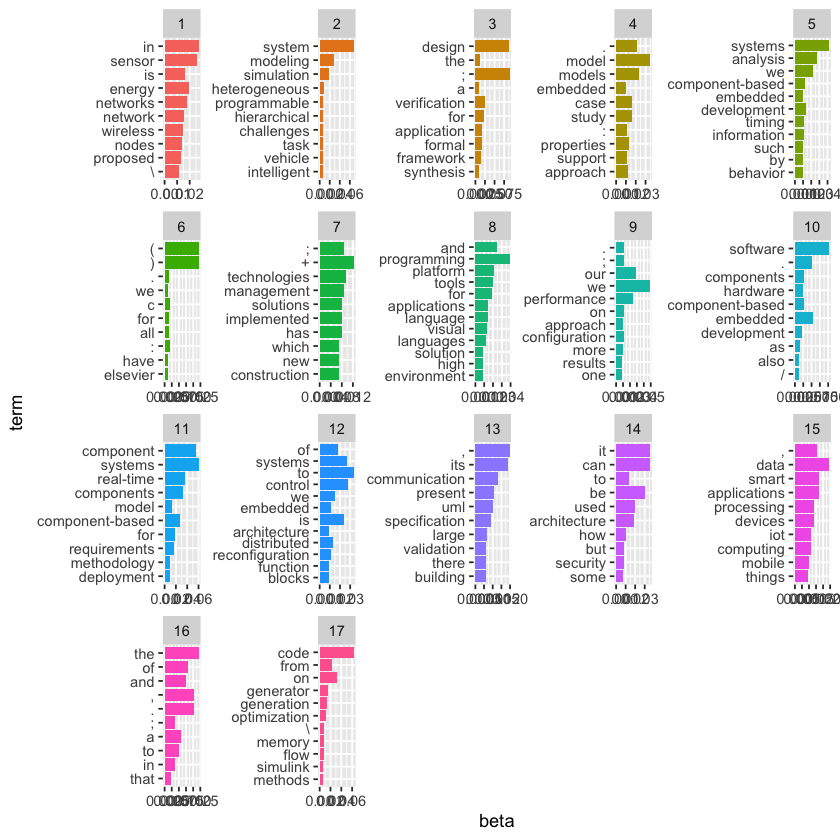

In [78]:
data.dtm.top_terms %>%
  mutate(term = reorder(term, beta)) %>%
  ggplot(aes(term, beta, fill=factor(topic))) +
  geom_col(show.legend = FALSE) +
  facet_wrap(~ topic, scales = "free") +
  coord_flip()

### Our proposal

#### Stemming with Spacy
- https://spacy.io - substantive subordinate operations

In [30]:
spacy = import("spacy")
nlp = spacy$load('en_core_web_sm')